# DCGAN的特点
- 判别模型：使用带步长的卷积（strided convolutions）取代了空间池化（spatial pooling）,容许网络学习自己的空间下采样（spatial downsampling）
- 生成模型：使用微步幅卷积（fractional strided）,容许它学习自己的空间上采样（spatial upsampling）。
- 激活函数：LeakyReLU
- Batch Normalization 批标准化：解决因糟糕的初始化引起的训练问题，使得梯度能传播更深层次。Batch Normalization证明了生成模型初始化的重要性，避免生成模型崩溃：生成的所有样本都在一个点上（样本相同），这是训练GANs经常遇到的失败现象。

# 反卷积
- 就是把卷积的前向和反向传播完全颠倒了

In [2]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
    
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='input_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

# 生成器


In [4]:
def get_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    with tf.variable_scope('generator', reuse=(not is_train)):
        # 100x1 to 4x4x512
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        # batch normalization
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4x4x512 to 7x7x256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7x7x256 to 14x14x128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 14x14x128 to 28x28x1
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        # MNIST原始数据集的像素范围在0-1， 这里的生成图片范围为（-1,1）
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs

# 判别器

In [5]:
def get_discriminator(inputs_img, reuse=False, alpha=0.01):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x1 to 14x14x128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 14x14x128 to 7x7x256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7x7x256 to 4x4x512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4x4x512 to 4x4x512x1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs
    

# 目标函数

In [6]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    
    g_outputs = get_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = get_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, reuse=True)
    
    # 计算loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels = tf.ones_like(d_outputs_fake)*(1-smooth)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                   labels = tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels = tf.zeros_like(d_outputs_fake)*(1-smooth)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

# 优化器

In [7]:
def get_optimizer(g_loss, d_loss, betal=0.4, learning_rate=0.001):
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

In [8]:
def plot_images(samples):
    fig, axes = plt.subplots(figsize=(50,2), nrows=1, ncols=25, sharex=True, sharey=True)
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [20]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    
    cmap = 'Greys_r'  
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪音图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])
    
    samples = sess.run(get_generator(inputs_noise, output_dim, False),
                       feed_dict = {inputs_noise:examples_noise})
    return samples

In [21]:
batch_size = 64
noise_size = 100
epochs = 5
n_samples = 25
learning_rate = 0.001

In [22]:
def train(noise_size, data_shape, batch_size, n_samples):
    
    # 存储loss
    losses = []
    steps=0
    betal=0.4
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, betal, learning_rate)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(mnist.train.num_examples//batch_size):
                steps += 1
                batch = mnist.train.next_batch(batch_size)

                batch_images = batch[0].reshape((batch_size, data_shape[1], data_shape[2], data_shape[3]))
                #对图像像素进行scale, 这是因为tanh的输出结果结余（-1,1），real和fake图片共享discriminator的参数
                batch_images = batch_images*2 - 1

                # generator的输入噪声
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # Run optimizers
                _ = sess.run(g_train_opt, feed_dict={inputs_real:batch_images, inputs_noise:batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real:batch_images, inputs_noise:batch_noise})
               
                if steps % 101 == 0:
                    train_loss_d = d_loss.eval({inputs_real:batch_images, inputs_noise:batch_noise})
                    train_loss_g = g_loss.eval({inputs_real:batch_images, inputs_noise:batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print('Epoch {}/{}...'.format(e+1,epochs),
                             "判别器损失{:.4f}".format(train_loss_d),
                              "生成器损失{:.4f}".format(train_loss_g)
                        )

Epoch 1/5... 判别器损失0.3787 生成器损失5.1499
Epoch 1/5... 判别器损失0.4386 生成器损失6.3955
Epoch 1/5... 判别器损失0.4237 生成器损失9.6088
Epoch 1/5... 判别器损失0.3636 生成器损失6.6184
Epoch 1/5... 判别器损失0.3447 生成器损失6.2283
Epoch 1/5... 判别器损失0.4061 生成器损失6.0685
Epoch 1/5... 判别器损失0.4009 生成器损失6.3031
Epoch 1/5... 判别器损失0.3544 生成器损失9.2704
Epoch 2/5... 判别器损失0.3392 生成器损失7.1895
Epoch 2/5... 判别器损失0.3565 生成器损失4.5287
Epoch 2/5... 判别器损失0.4020 生成器损失6.7001
Epoch 2/5... 判别器损失0.3774 生成器损失6.9288
Epoch 2/5... 判别器损失0.3585 生成器损失5.0333
Epoch 2/5... 判别器损失0.5312 生成器损失2.1744
Epoch 2/5... 判别器损失0.3713 生成器损失3.6285
Epoch 2/5... 判别器损失0.3360 生成器损失6.9041
Epoch 2/5... 判别器损失0.3602 生成器损失6.7572
Epoch 3/5... 判别器损失0.4357 生成器损失4.7009
Epoch 3/5... 判别器损失0.3754 生成器损失6.1099
Epoch 3/5... 判别器损失0.4060 生成器损失6.5236
Epoch 3/5... 判别器损失0.5036 生成器损失7.6200
Epoch 3/5... 判别器损失0.3807 生成器损失3.6259
Epoch 3/5... 判别器损失0.4733 生成器损失2.8693
Epoch 3/5... 判别器损失0.4082 生成器损失4.1450
Epoch 3/5... 判别器损失0.4347 生成器损失4.9305
Epoch 4/5... 判别器损失0.4283 生成器损失3.3909
Epoch 4/5... 判别器损失0.5647 生成器损失6.3619
E

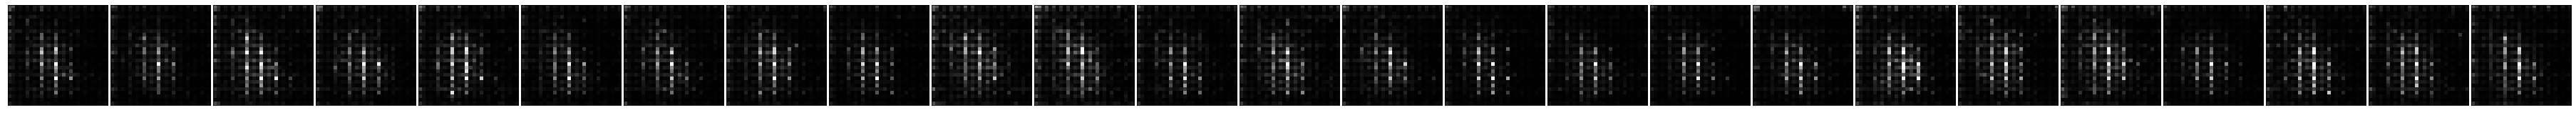

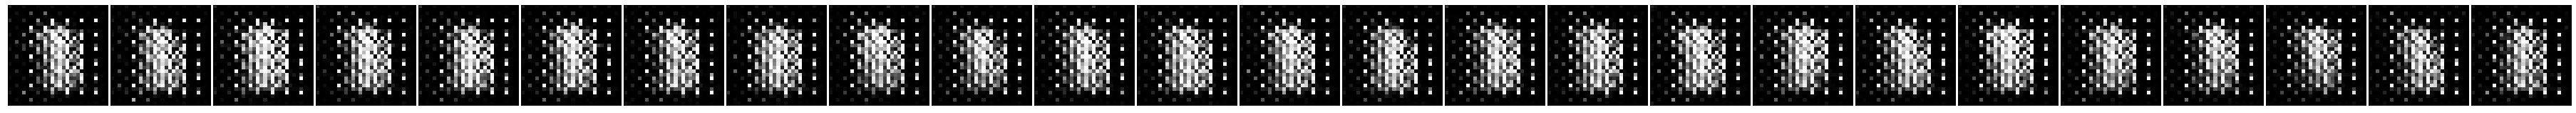

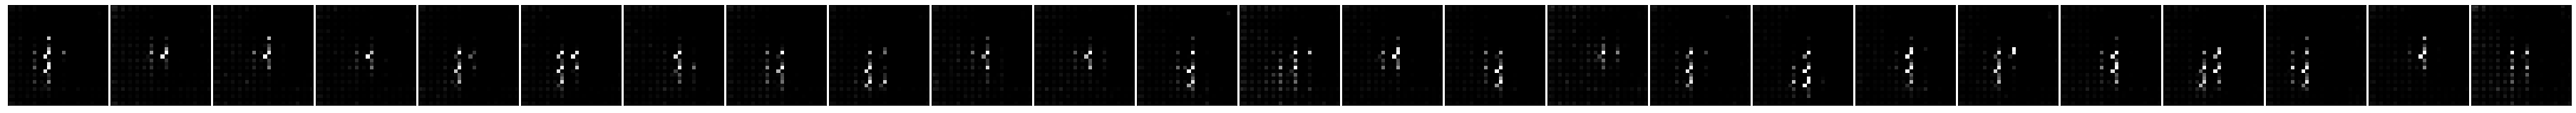

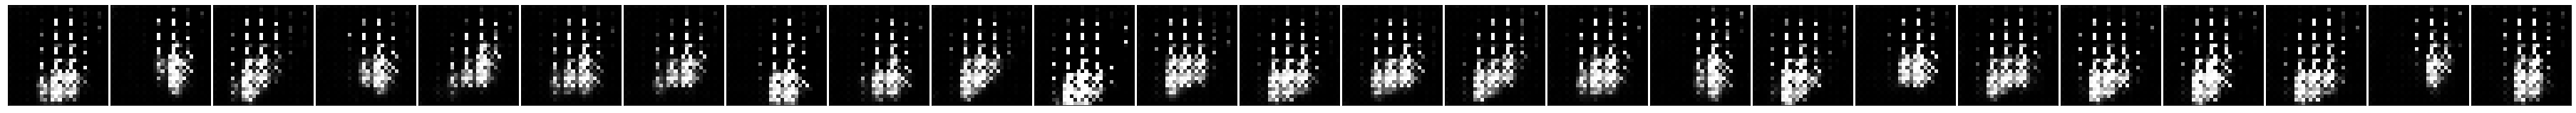

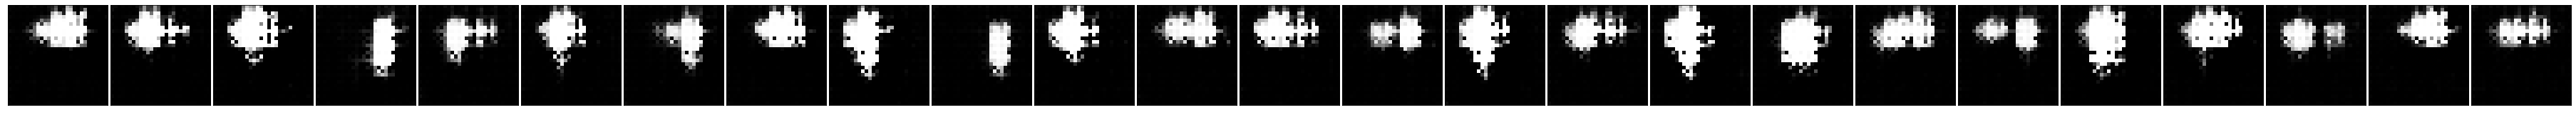

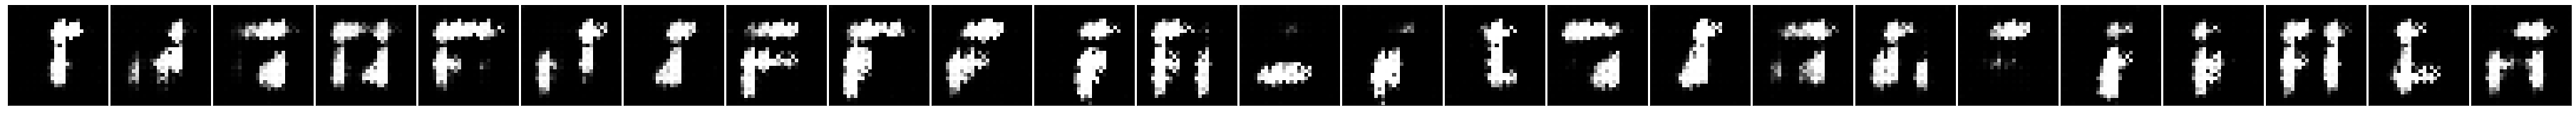

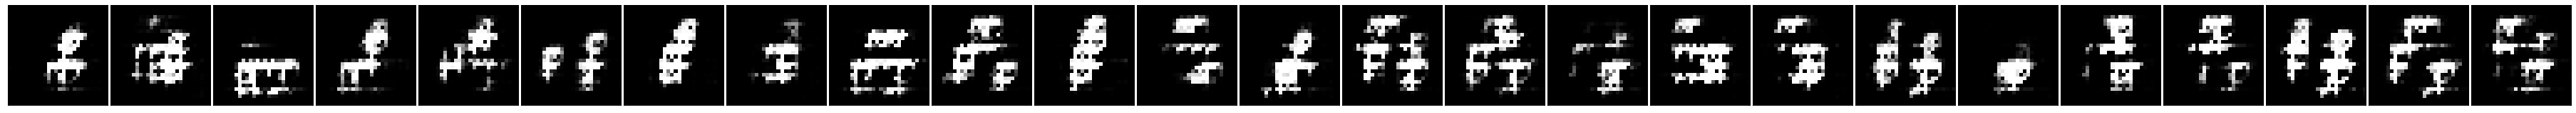

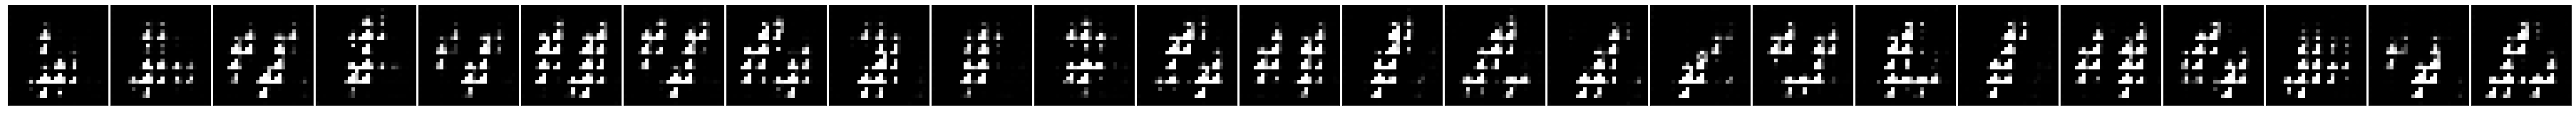

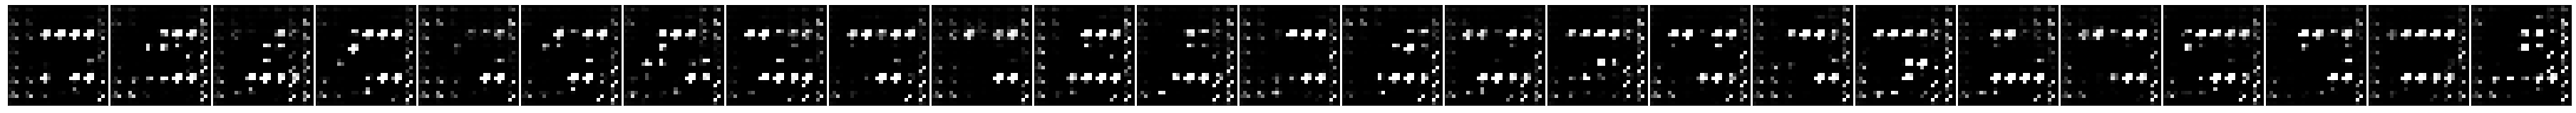

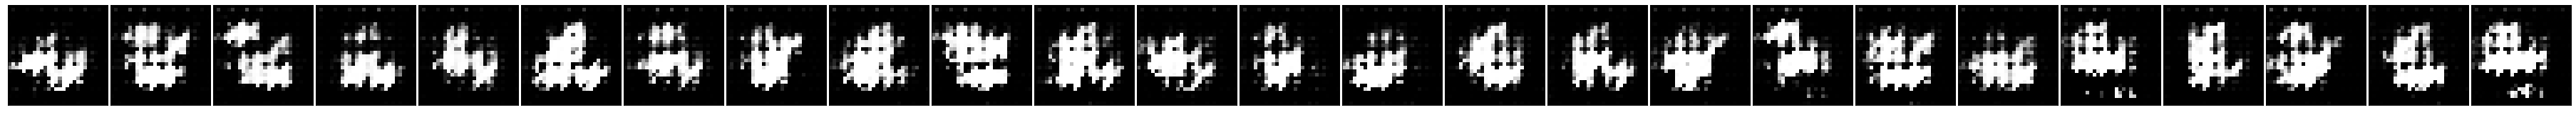

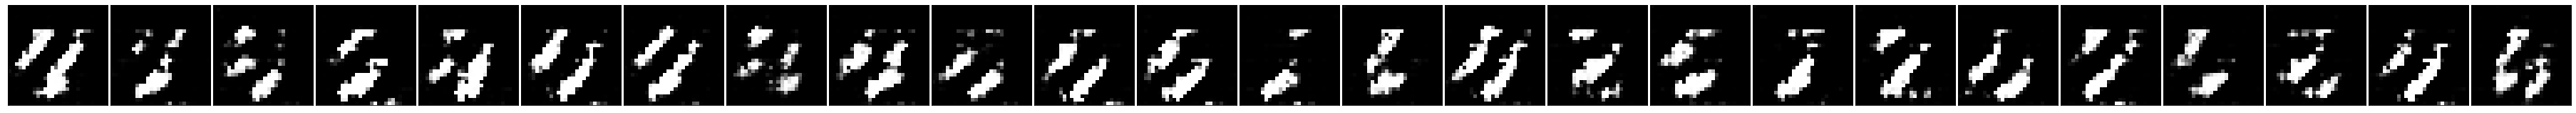

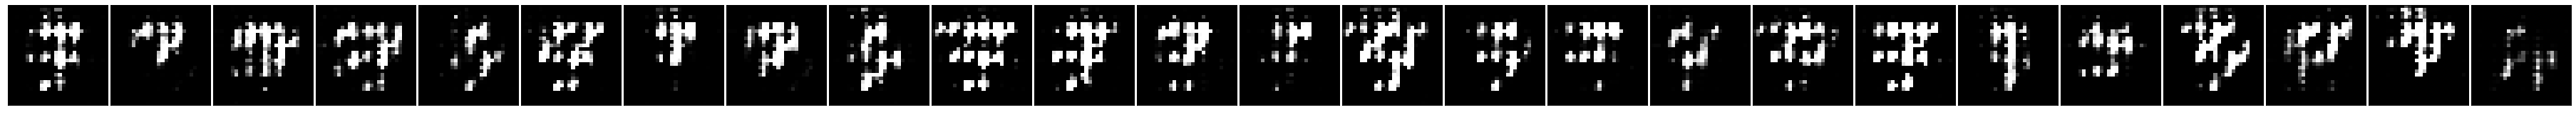

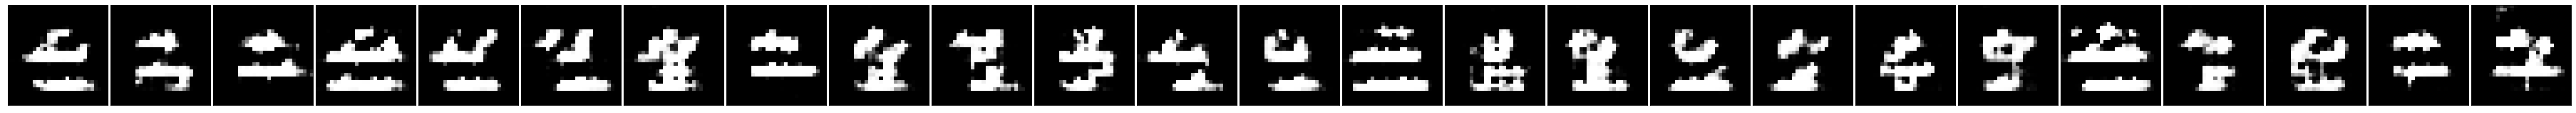

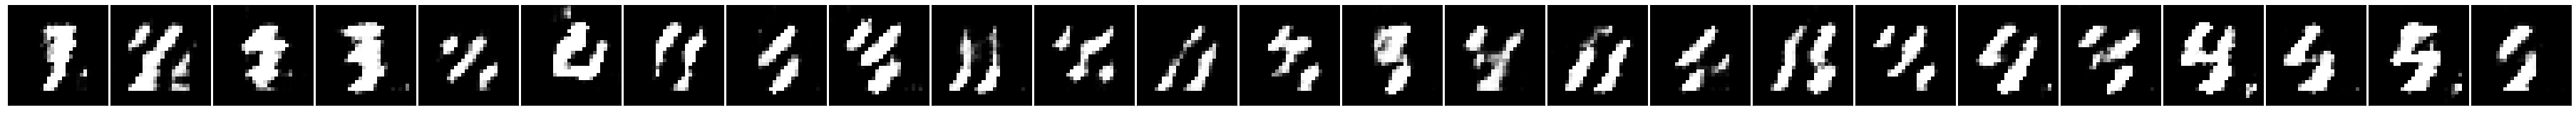

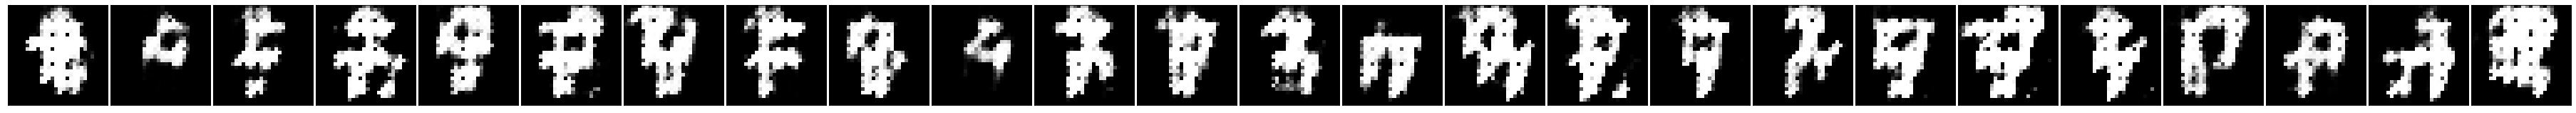

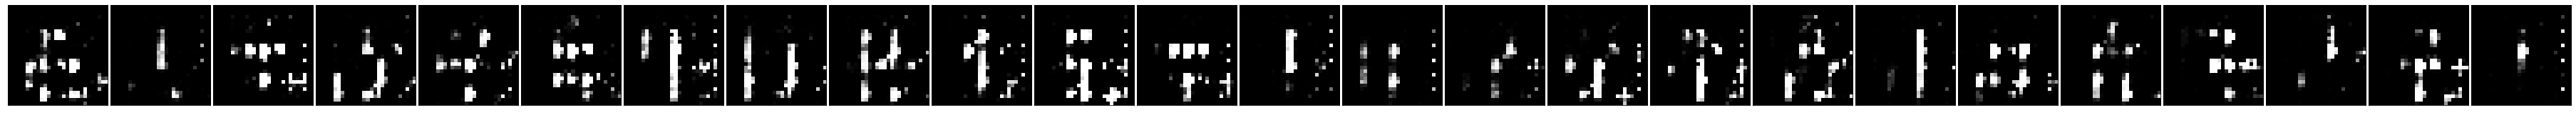

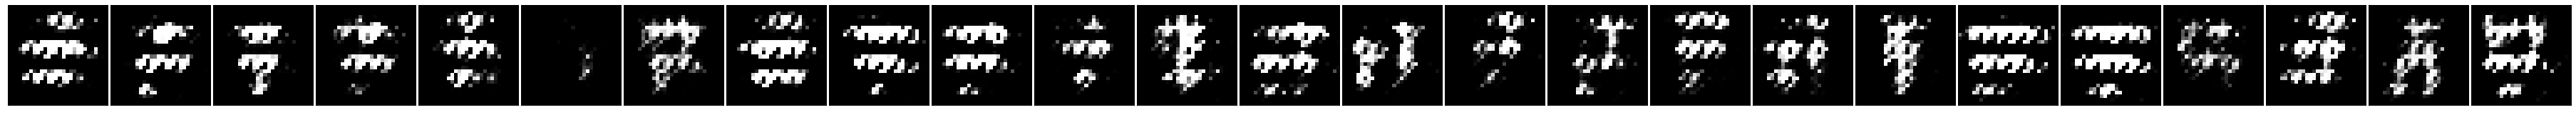

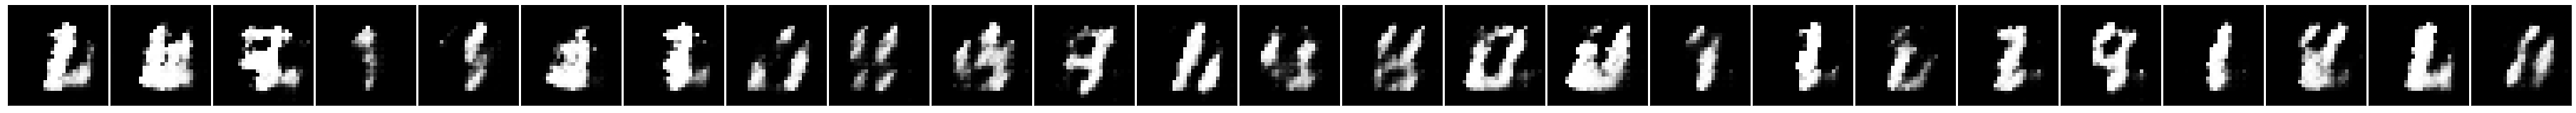

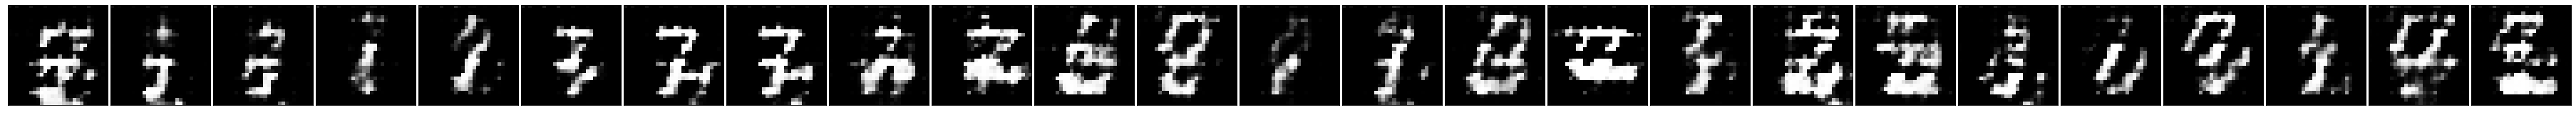

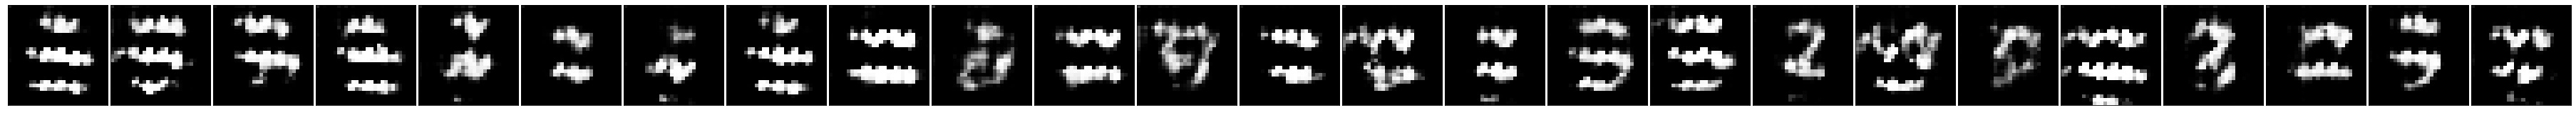

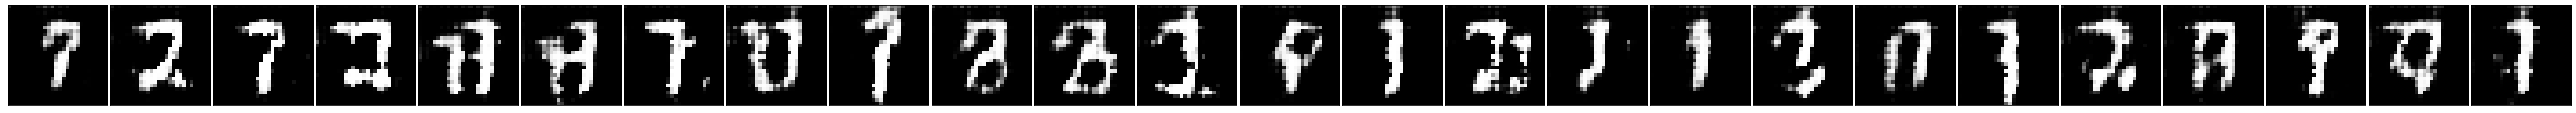

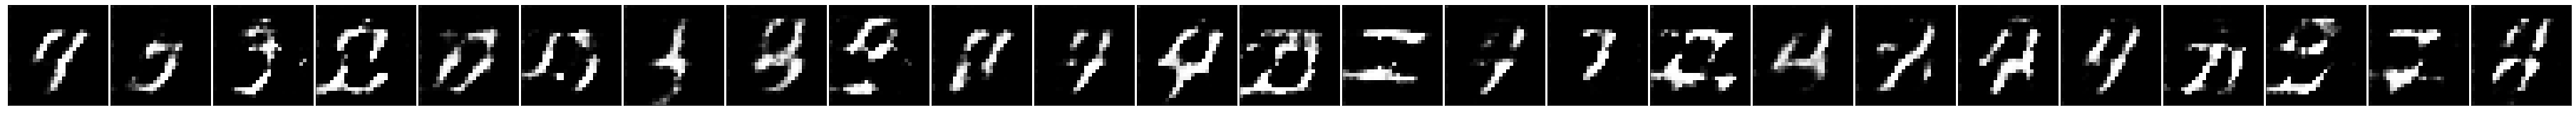

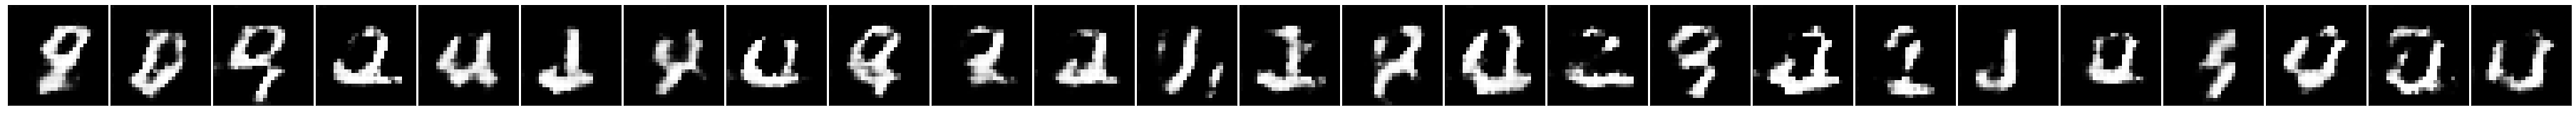

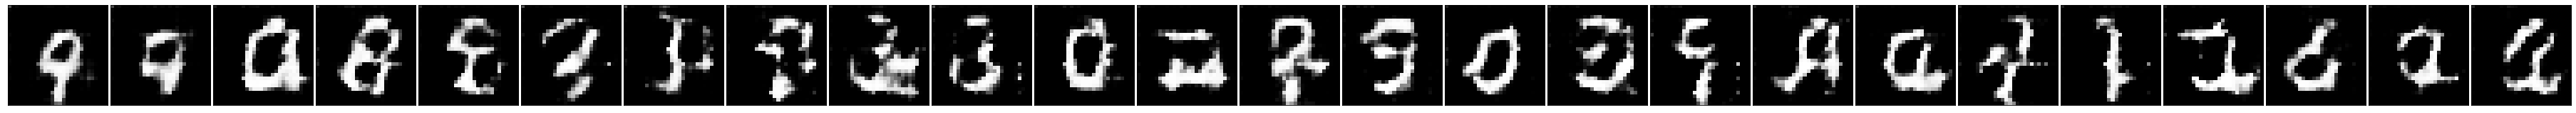

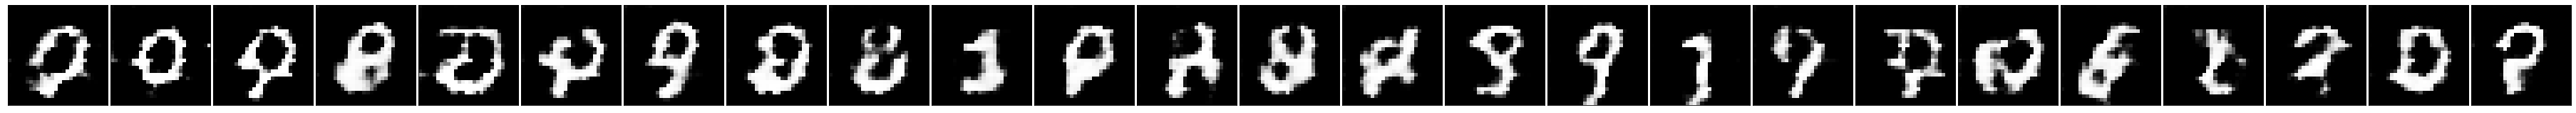

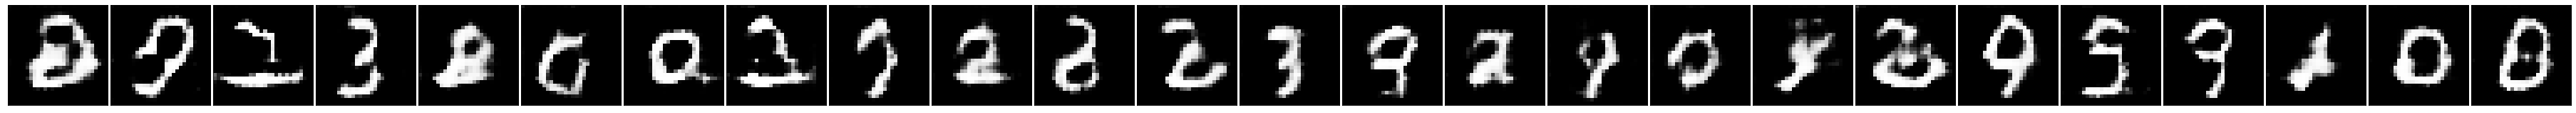

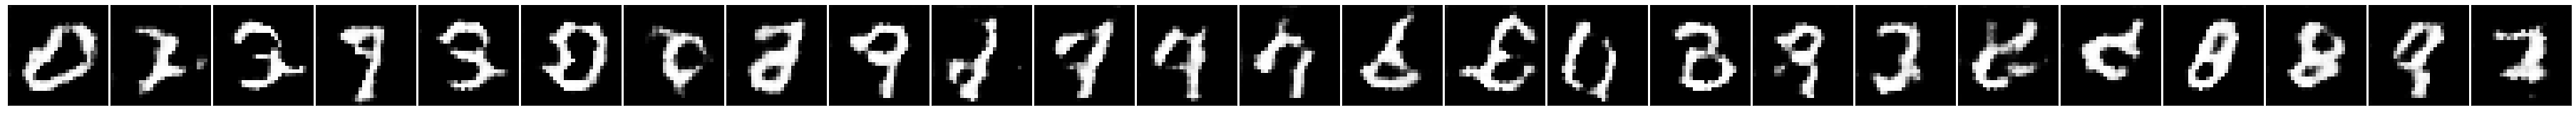

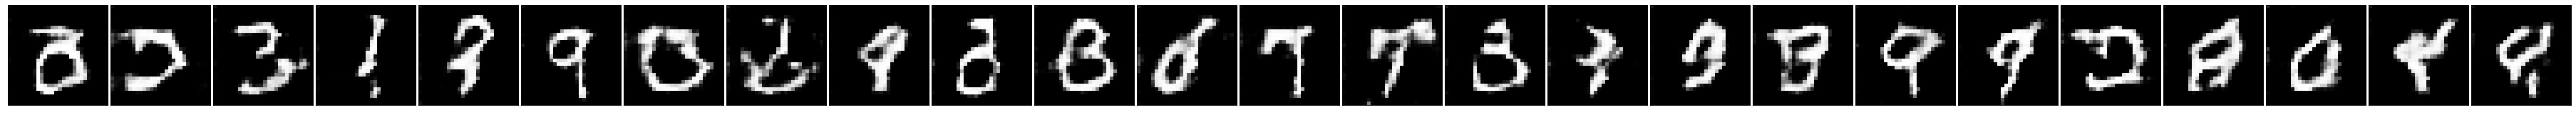

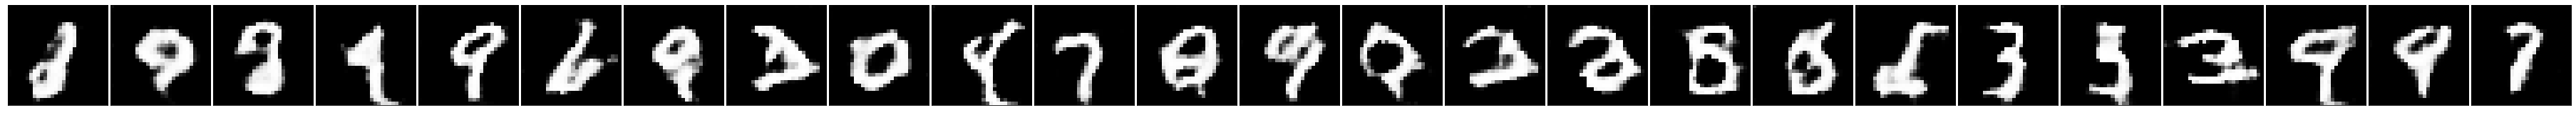

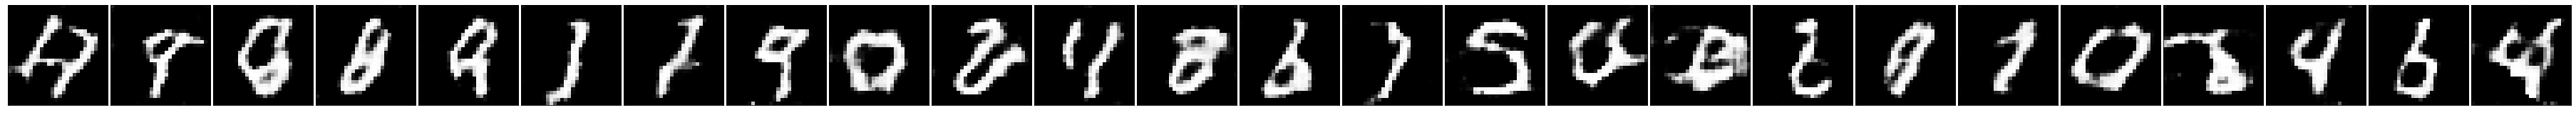

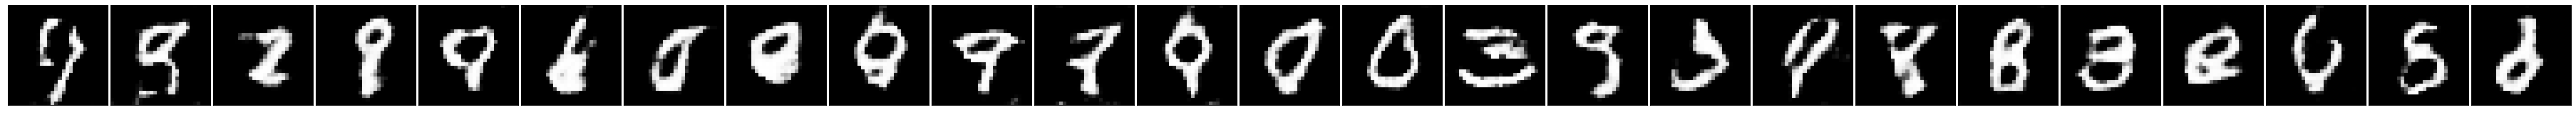

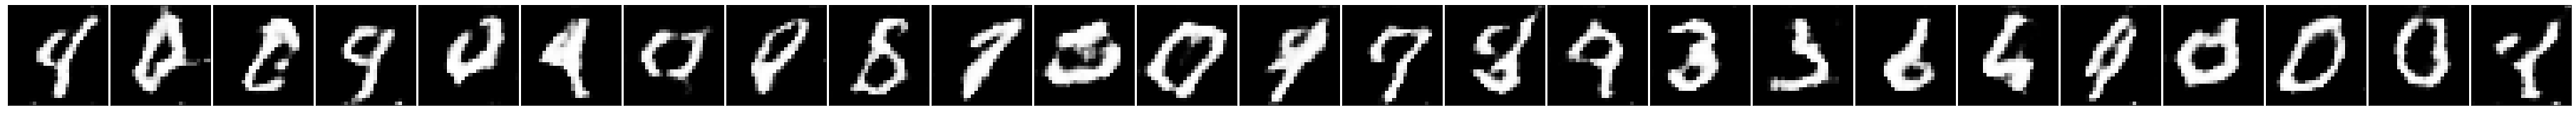

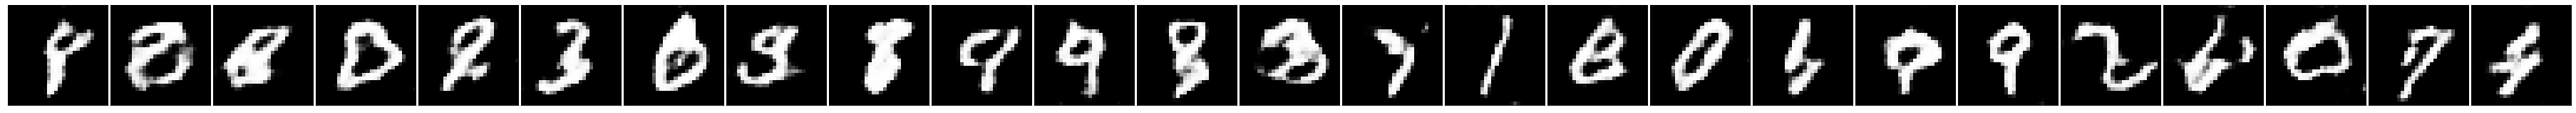

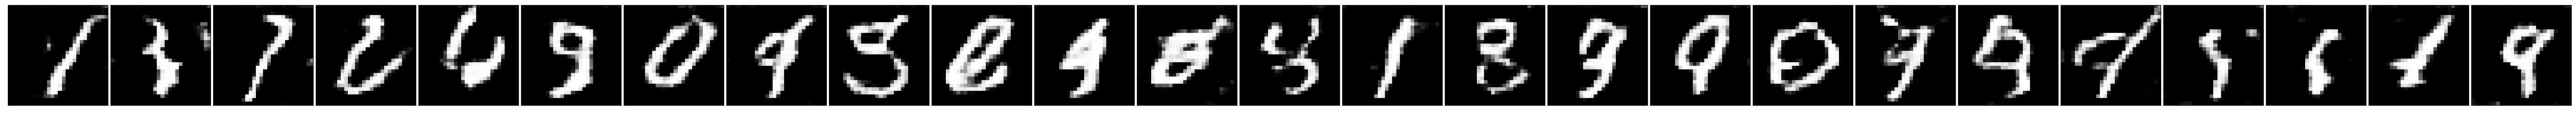

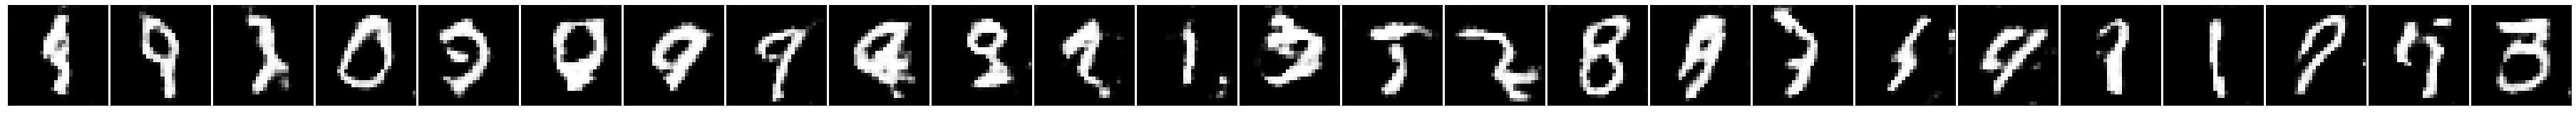

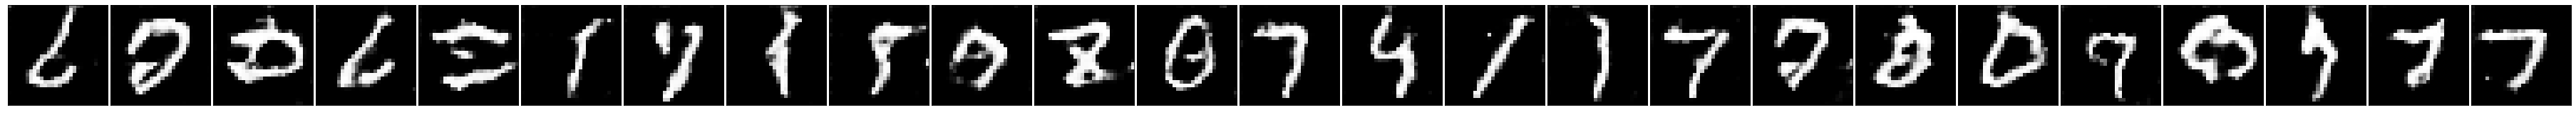

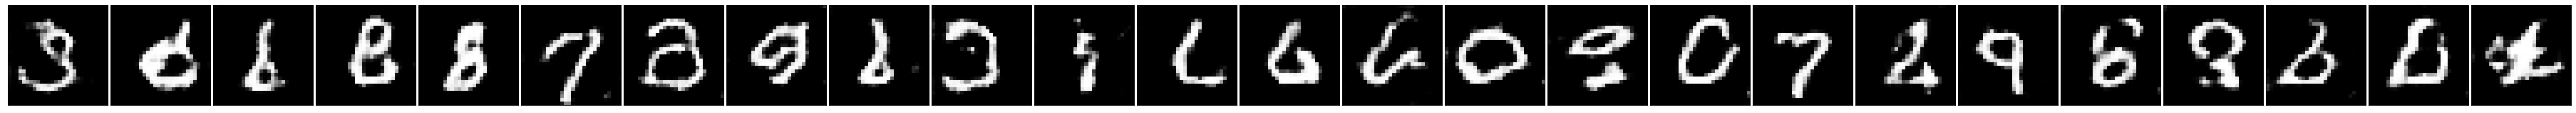

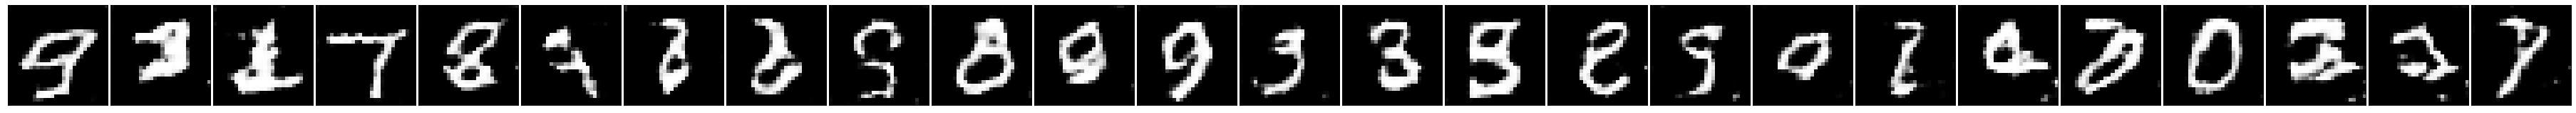

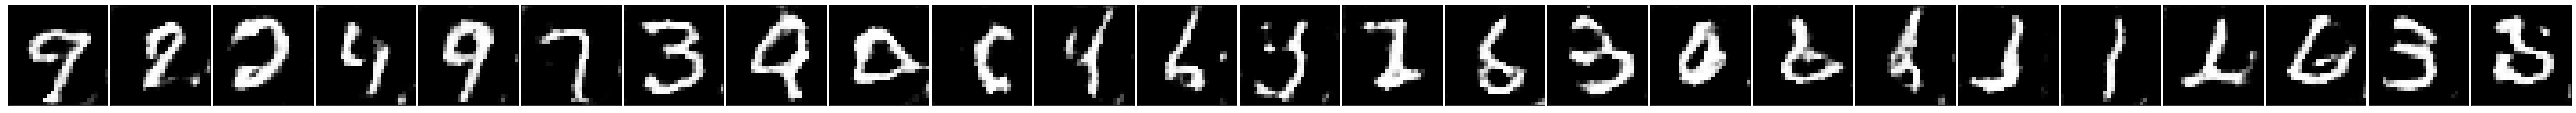

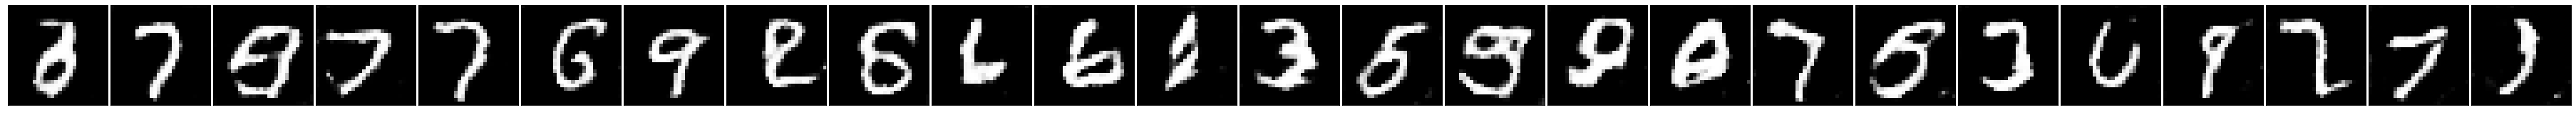

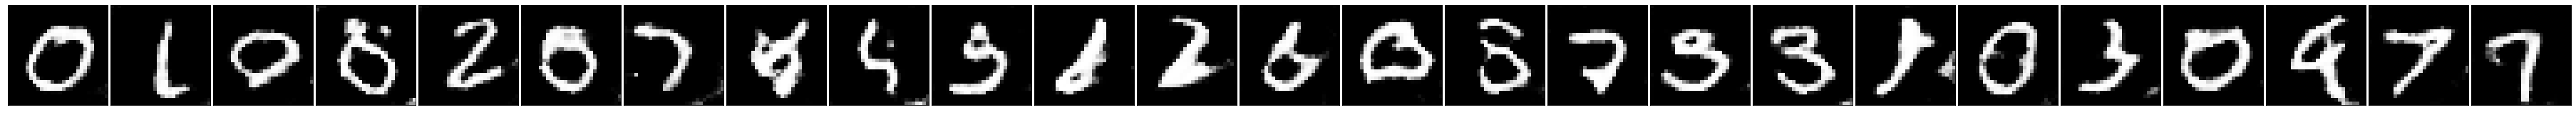

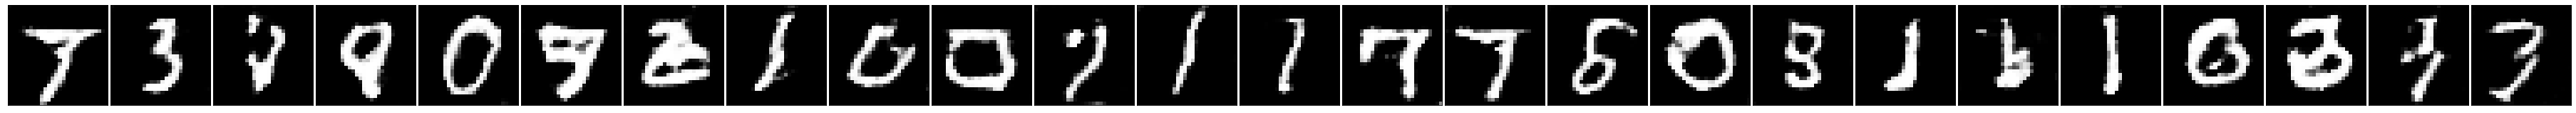

In [23]:
with tf.Graph().as_default():
    train(noise_size, [-1, 28, 28, 1], batch_size, n_samples)